In [29]:
# import libraries
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from tensorflow.keras.regularizers import L1
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

# import data (available at https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia?datasetId=724418&sortBy=voteCount)
data_directory = "../input/chest-xray-covid19-pneumonia/Data"
train_directory = data_directory+"/train"
test_directory = data_directory+"/test"
os.listdir(test_directory)

['PNEUMONIA', 'NORMAL', 'COVID19']

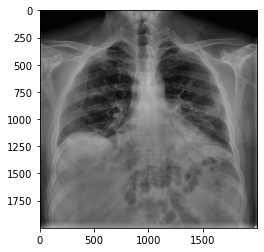

In [7]:
pneumonia_sample = imread(train_directory+"/PNEUMONIA"+"/PNEUMONIA(50).jpg")
plt.imshow(pneumonia_sample)

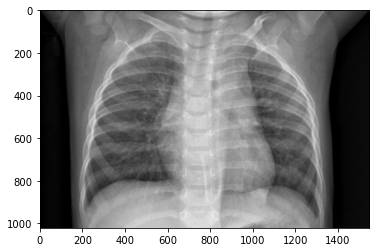

In [8]:
normal_sample = imread(train_directory+"/NORMAL"+"/NORMAL(40).jpg")
plt.imshow(normal_sample)

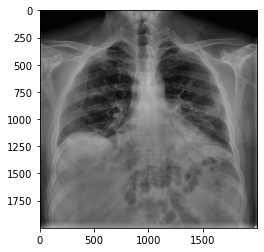

In [9]:
covid_sample = imread(train_directory+"/COVID19"+"/COVID19(5).jpg")
plt.imshow(covid_sample, cmap= "gray")

In [13]:
#Data Augmentation
generator = ImageDataGenerator(
    width_shift_range=0.09,
    height_shift_range=0.09,
    shear_range=0.1,
    zoom_range=0.15,
    fill_mode='nearest',
    rescale=1/255,
)

# Apply the generator to the training images.
# Here we also reshape the images to grayscale 400x400 and choose a batch size = 16.
# Batch size specifies how many new images are created per original image.

train_generator = generator.flow_from_directory (
    train_directory,
    target_size=(400,400),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
)

# Repeat for the test images

test_generator = generator.flow_from_directory (
    test_directory,
    target_size=(400,400),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [44]:
# build model
model = Sequential()
# convolution layer and batch norm
model.add(Conv2D(filters = 16, padding = "same", kernel_size = 2, strides = 2, kernel_initializer = 'HeNormal',
                 activation = "relu", input_shape = (400,400,1)))
model.add(BatchNormalization())
# max pooling layer
model.add(MaxPool2D(pool_size = (2,2), strides = 1))

# convolution layer and batch norm
model.add(Conv2D(filters = 32, padding = "same", kernel_size = 2, strides = 2, kernel_initializer = 'HeNormal',
                 activation = "relu"))
model.add(BatchNormalization())
# max pooling layer
model.add(MaxPool2D(pool_size = (2,2), strides = 1))

# convolution layer and batch norm
model.add(Conv2D(filters = 64, padding = "same", kernel_size = 2, strides = 2, kernel_initializer = 'HeNormal',
                 activation = "relu"))
model.add(BatchNormalization())
# map pooling layer
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

# flatten the output feature map into a vector before passing through FCNN
model.add(Flatten())
# fully connected layer 1
model.add(Dense(units = 128, kernel_regularizer = L1(0.01), kernel_initializer = 'HeNormal',
                activation = "relu"))
# fully connected layer 2
model.add(Dense(units = 64, kernel_regularizer = L1(0.01), kernel_initializer = 'HeNormal', 
                activation = "relu"))
# output layer
model.add(Dense(units = 3, activation = "softmax"))

# choose Adam optimisation
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 200, 200, 16)      80        
_________________________________________________________________
batch_normalization_9 (Batch (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 199, 199, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 100, 32)      2080      
_________________________________________________________________
batch_normalization_10 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 64)       

In [45]:
# early stopping
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=6)

# train model
history = model.fit(train_generator, validation_data=test_generator, epochs=10, callbacks=[early_stop])

Epoch 1/10
322/322 [==============================] - 291s 901ms/step - loss: 60.4892 - accuracy: 0.7605 - val_loss: 11.0649 - val_accuracy: 0.7298
Epoch 2/10
322/322 [==============================] - 289s 896ms/step - loss: 10.1294 - accuracy: 0.8472 - val_loss: 8.5226 - val_accuracy: 0.8556
Epoch 3/10
322/322 [==============================] - 288s 895ms/step - loss: 8.2396 - accuracy: 0.8460 - val_loss: 7.2601 - val_accuracy: 0.8447
Epoch 4/10
322/322 [==============================] - 291s 902ms/step - loss: 7.3170 - accuracy: 0.8767 - val_loss: 6.9028 - val_accuracy: 0.8843
Epoch 5/10
322/322 [==============================] - 288s 892ms/step - loss: 6.9344 - accuracy: 0.8854 - val_loss: 6.6856 - val_accuracy: 0.8711
Epoch 6/10
322/322 [==============================] - 287s 891ms/step - loss: 6.6610 - accuracy: 0.8737 - val_loss: 6.9161 - val_accuracy: 0.7554
Epoch 7/10
322/322 [==============================] - 290s 900ms/step - loss: 6.4783 - accuracy: 0.8886 - val_loss: 6.486

In [46]:
#test model
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print('\nTest accuracy:', test_acc)

81/81 [==============================] - 44s 541ms/step - loss: 6.3063 - accuracy: 0.8952

Test accuracy: 0.8951863646507263


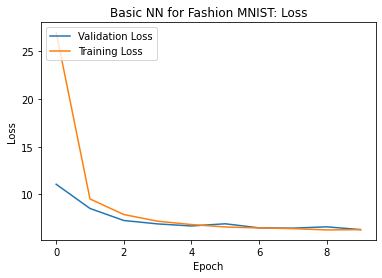

In [47]:
# val loss - epoch graph to see if we have overfit
plt.plot(history.history['val_loss']) 
plt.plot(history.history['loss'])
plt.title('Basic NN for Fashion MNIST: Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation Loss', "Training Loss"], loc='upper left')
plt.show()